In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp

### Иморт экспериментальных данных

- FTIAN 2

In [ ]:
z_arr = np.arange(14, 56, 2)
t_arr = np.array([3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]) * 10
data_input = np.zeros(shape=(len(z_arr), 2048, 2048))

for i, z in enumerate(z_arr):
    data_input[i] = np.loadtxt("FTIAN_2/data_input/"+str(z)+".asc").T[1::]
    data_input[i] = data_input[i] / t_arr[i] # нормировка по времени измерения

- FTIAN 3

In [70]:
z_arr = np.arange(16, 46, 2)
t_arr = np.array([30, 30, 25, 25, 20, 15, 15, 15, 15, 15, 20, 20, 25, 25, 30])
data_input = np.zeros(shape=(len(z_arr), 2048, 2048))

for i, z in enumerate(z_arr):
    data_input[i] = np.loadtxt("FTIAN_3/data_input/"+str(z)+".asc").T[1::]
    data_input[i] = data_input[i] / t_arr[i] # нормировка по времени измерения

- SNIGIREV

In [ ]:
z_arr = np.arange(14, 65, 2)
t_arr = np.concatenate([np.ones(5)*20, [15], np.ones(7)*10, [10, 15, 15], np.ones(7)*20, [25, 30, 30]])
data_input = np.zeros(shape=(len(z_arr), 2046, 2046))

for i, z in enumerate(z_arr):
    data_input[i] = np.loadtxt("SNIGIREV/data_input/"+str(z)+"_"+str(int(t_arr[i]))+".asc").T[1::]
    data_input[i] = data_input[i] / t_arr[i] # нормировка по времени измерения

- SILA 1

In [ ]:
z_arr = np.array([26, 30, 34])
t_arr = 30
data_input = np.zeros(shape=(len(z_arr), 2048, 2048))

for i, z in enumerate(z_arr):
    data_input[i] = np.loadtxt("SILA/data_input/1/"+str(z)+".asc").T[1::]
    data_input[i] = data_input[i] / t_arr # нормировка по времени измерения

### Проверка импортируемых данных и инициализация сетки

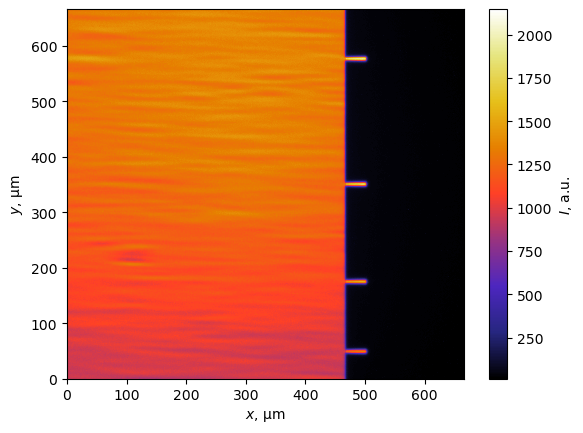

In [71]:
def plot_pcolor(x, y, data):
    %matplotlib inline
    fig, ax = plt.subplots(1, 1)
    colbar = plt.pcolormesh(x, y, data, cmap='CMRmap')
    cbar = fig.colorbar(colbar)
    cbar.set_label('$I$, a.u.')
    # plt.xlim(250, 350)
    # plt.ylim(0, 100)
    plt.xlabel("$x$, μm")
    plt.ylabel("$y$, μm")
    fig.canvas.draw()

dx_input = 0.325
dy_input = 0.325
Nz, Nx, Ny = data_input.shape
x_input = np.linspace(0, Nx*dx_input, Nx)
y_input = np.linspace(0, Ny*dy_input, Ny)

plot_pcolor(x_input, y_input, data_input[0])

data_input = cp.array(data_input, dtype=cp.float32)

### Очистка данных от данных битых пикселей (медианный фильтр)

In [72]:
def clean_xray_image_stack(image_stack, median_filter_size=3, threshold_factor=3):
  """
  Очищает стек рентгеновских изображений от аномальных выбросов (горячих пикселей).

  Args:
    image_stack: NumPy массив формы (21, 2048, 2048), представляющий стек рентгеновских изображений.
    median_filter_size: Размер ядра медианного фильтра. Нечетное число, определяющее размер окрестности
                        для вычисления медианного значения.  Типичные значения: 3, 5, 7.
    threshold_factor:  Фактор, определяющий порог для обнаружения выбросов.  Умножается на стандартное отклонение
                       окрестности пикселя.  Более высокое значение делает детектор выбросов менее чувствительным.

  Returns:
    NumPy массив той же формы, что и входной, с очищенными изображениями.
  """

  is_numpy = isinstance(image_stack, np.ndarray)
  xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
  if is_numpy:
      import scipy.ndimage as ndimage
  else:
      import cupyx.scipy.ndimage as ndimage

  cleaned_stack = xp.zeros_like(image_stack)

  for i in range(image_stack.shape[0]):  # Итерируемся по кадрам
    frame = image_stack[i]

    # 1. Медианный фильтр для начального обнаружения и оценки фона
    #    Медианный фильтр эффективно удаляет выбросы, сохраняя при этом структуру изображения.
    median_filtered = ndimage.median_filter(frame, size=median_filter_size)

    # 2. Вычисление разницы между оригинальным изображением и отфильтрованным
    difference = np.abs(frame - median_filtered)

    # 3. Вычисление стандартного отклонения разницы в окрестности каждого пикселя
    #    Используем фильтр стандартного отклонения.  Можно использовать `scipy.ndimage.generic_filter`
    #    с функцией, вычисляющей стандартное отклонение.  Для простоты можно использовать медианный фильтр
    #    разницы и затем умножить результат на оценочный коэффициент для стандартного отклонения.
    #    Медианный фильтр эффективно сглаживает разницу, обеспечивая оценку локального стандартного отклонения.
    #    Альтернативно, можно использовать свертку с ядром для оценки стандартного отклонения, но это
    #    требует более тщательной настройки параметров ядра.
    std_dev_estimate = ndimage.median_filter(difference, size=median_filter_size) * 1.4826  # 1.4826 приближает std при нормальном распределении

    # 4. Создание маски выбросов
    #    Пиксели, отклоняющиеся от медианного фильтра больше, чем threshold_factor * std_dev_estimate,
    #    считаются выбросами.
    outlier_mask = difference > (threshold_factor * std_dev_estimate)

    # 5. Замена выбросов медианными значениями
    #    Заменяем значения выбросов медианными значениями из отфильтрованного изображения.
    cleaned_frame = frame.copy()  # Создаем копию, чтобы не менять исходный кадр
    cleaned_frame[outlier_mask] = median_filtered[outlier_mask]

    cleaned_stack[i] = cleaned_frame

  return cleaned_stack

data_corrected = clean_xray_image_stack(data_input)

### Поиск границы, делящей кадр

In [73]:
def border_filter(image_stack):
    is_numpy = isinstance(image_stack, np.ndarray)
    xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
    
    N = len(image_stack)
    res_data = xp.empty(shape=image_stack.shape)
    for k in range(N):
        frame_0 = image_stack[k].copy()
        frame_0 = np.log1p(frame_0)
        gr1 = np.gradient(frame_0, axis=1)
        gr0 = np.gradient(frame_0, axis=0)
        # frame_0 = gr1**2/np.mean(gr1**2) + gr0**2/np.mean(gr0**2)
        frame_0 = gr1**2 + gr0**2
        frame_0 /= np.max(frame_0)
        # frame_0 = np.round(frame_0)
        # frame_0 /= np.mean(frame_0)
        # frame_0[frame_0 < 0.8*np.mean(frame_0)] = 0
        # frame_0[frame_0 > 1.2*np.mean(frame_0)] = 0
        # frame_0[frame_0<0.5] = 0
        # frame_0[frame_0!=0] = 1
        res_data[k] = frame_0 / np.max(frame_0)
    return res_data

ust_obj_border = border_filter(data_corrected)

def plot_pcolor_slider_pixel(data_input):
    data = data_input.copy()
    is_numpy = isinstance(data, np.ndarray)
    if not is_numpy:
        data = data.get()
    data /= np.max(data)
    
    from matplotlib.widgets import Slider
    # plt.clf()
    %matplotlib tk
    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.2)
    ax.set_aspect('equal')
    # Начальное отображение
    c = ax.pcolormesh(data[0]/np.max(data), rasterized=True, cmap='CMRmap', vmin=0, vmax=1)
    # ax.grid()
    # plt.title(f'z = {z[0]}')
    plt.colorbar(c)
    # plt.xlim(-20, 20)
    # plt.ylim(-20, 20)
    # Настраиваем слайдер
    ax_slider = plt.axes([0.3, 0.05, 0.45, 0.03])  # (left, bottom, width, height)
    slider = Slider(ax_slider, 'Index', 0, len(data)-1, valinit=0, valstep=1)

    # Функция обновления графика при изменении слайдера
    def update(val):
        idx = int(slider.val)
        c.set_array(data[idx].flatten())
        # c.set_array(data[idx].flatten()/np.max(data[idx].flatten()))
        # ax.set_title(f'z = {z[idx]}')
        fig.canvas.draw()

    slider.on_changed(update)

plot_pcolor_slider_pixel(ust_obj_border)

### Выравнивание юстировочной границы

In [74]:
def align_stack_with_shifts(image_stack):
    """
    Выравнивает изображения в стеке относительно первого и возвращает сдвиги, используя GPU.

    :param image_stack: numpy массив формы (21, 2048, 2048)
    :return: (aligned_stack, shifts)
             aligned_stack — numpy массив той же формы с выровненными изображениями
             shifts — numpy массив формы (21, 2) с (dx, dy) сдвигами
    """
    
    is_cupy = isinstance(image_stack, cp.ndarray)
    xp = cp if is_cupy else np # Выбираем модуль: cupy или numpy
    if is_cupy:
        import cupyx.scipy.ndimage as ndimage
    else:
        import scipy.ndimage as ndimage

    num_frames, height, width = image_stack.shape
    
    # Переносим стек изображений на GPU
    image_stack_gpu = xp.asarray(image_stack)

    reference = image_stack_gpu[0].astype(xp.float32)
    aligned_stack = xp.zeros_like(image_stack_gpu, dtype=xp.float32)
    shifts = xp.zeros((num_frames, 2), dtype=cp.float32)

    aligned_stack[0] = image_stack[0]
    shifts[0] = xp.array([0.0, 0.0])  # Эталонное изображение без сдвига

    for i in range(1, num_frames):
        current = image_stack_gpu[i].astype(xp.float32)

        # Вычисление сдвига с использованием корреляции по фазе на GPU
        cross_power_spectrum = xp.fft.fft2(reference) * xp.fft.fft2(current).conj()
        cross_correlation = xp.fft.ifft2(cross_power_spectrum)
        shift = cp.unravel_index(xp.argmax(xp.abs(cross_correlation)), cross_correlation.shape)
        dy, dx = shift[0].item(), shift[1].item() # Получаем Python scalar'ы из NumPy массива

        # Преобразование координат сдвига
        if dx > width // 2:
            dx -= width
        if dy > height // 2:
            dy -= height

        shifts[i] = xp.array([float(dx), float(dy)])

        shifted = ndimage.shift(image_stack[i], shift=(dy, dx), mode='nearest')
        aligned_stack[i] = shifted
    
    return aligned_stack, shifts

ust_obj_border_aligned, shifts = align_stack_with_shifts(ust_obj_border)
plot_pcolor_slider_pixel(ust_obj_border_aligned)

### Сдвиг кадров

In [75]:
def apply_shifts(image_stack, shifts):
    """
    Выравнивает изображения в стеке относительно первого и возвращает сдвиги, используя GPU.

    :param image_stack: numpy массив формы (21, 2048, 2048)
    :return: (aligned_stack, shifts)
             aligned_stack — numpy массив той же формы с выровненными изображениями
             shifts — numpy массив формы (21, 2) с (dx, dy) сдвигами
    """
    
    is_numpy = isinstance(image_stack, np.ndarray)
    xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
    if is_numpy:
        import scipy.ndimage as ndimage
    else:
        import cupyx.scipy.ndimage as ndimage

    num_frames, height, width = image_stack.shape
    
    # Переносим стек изображений на GPU
    image_stack_gpu = xp.asarray(image_stack)
    shifted_stack = xp.zeros_like(image_stack_gpu, dtype=xp.float32)
    shifted_stack[0] = image_stack[0]

    for i in range(1, num_frames):
        shift = shifts[i]
        dy, dx = shift[0].item(), shift[1].item() # Получаем Python scalar'ы из NumPy массива
        # Преобразование координат сдвига
        if dx > width // 2:
            dx -= width
        if dy > height // 2:
            dy -= height
        shifted = ndimage.shift(image_stack[i], shift=(dx, dy), mode='nearest')
        shifted_stack[i] = shifted
    
    return shifted_stack

data_shifted = apply_shifts(data_corrected, shifts)

plot_pcolor_slider_pixel(data_shifted)

### Поворот кадров (при необходимости)

In [76]:
from cupyx.scipy import ndimage

def rotate_stack(stack: cp.ndarray, angle: float) -> cp.ndarray:
  """
  Поворачивает каждый кадр в стаке cupy массивов на заданный угол.
  """

  rotated_stack = cp.empty_like(stack)

  for i in range(stack.shape[0]):
    rotated_stack[i] = ndimage.rotate(stack[i], angle, reshape=False)

  return rotated_stack

rotate_angle = 0 # ALL
# rotate_angle = -0.5 # SNIGIREV
# rotate_angle = 0.5 # SILA 1

data_rotated = rotate_stack(data_shifted, rotate_angle)
# plot_pcolor_slider_pixel(data_final_rotate)
plt.pcolormesh(data_rotated[0].get())
plt.grid()

### Вырезание нужного объекта в кадре

In [77]:
def cutter_stack(image_stack, i, j, pix_size):
    N = len(image_stack)
    is_numpy = isinstance(image_stack, np.ndarray)
    xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
    res_data = xp.empty(shape=(N, pix_size*2, pix_size*2))
    for k in range(N):
        res_data[k] = image_stack[k, i-pix_size:i+pix_size, j-pix_size:j+pix_size]
    return res_data

# Y_POS, X_POS, SIZE_PIX = 1267, 1407, 70 # FTIAN_2 POS
Y_POS, X_POS, SIZE_PIX = 538, 1495, 90 # FTIAN_3 POS
# Y_POS, X_POS, SIZE_PIX = 1330, 1495, 120 # SNIGIREV POS
# Y_POS, X_POS, SIZE_PIX = 605, 940, 120 # SILA_1 POS

data_cutted = cutter_stack(data_rotated, Y_POS, X_POS, SIZE_PIX)

# plot_pcolor_slider_pixel(data_final/np.max(data_final))

x_final = np.linspace(0, SIZE_PIX*2*dx_input, SIZE_PIX*2)
y_final = np.linspace(0, SIZE_PIX*2*dy_input, SIZE_PIX*2)

x_final -= x_final[SIZE_PIX]
y_final -= y_final[SIZE_PIX]

plot_pcolor_slider_pixel(data_cutted)

### Сшивка путем поиска середины границы вакуум-среда, а также центрирование через аппроксимацию гауссом

In [78]:
from scipy.optimize import curve_fit

def gaussian_approximation_1d(data, subpixel=True):
  """
  Аппроксимирует 1D массив функцией Гаусса и выдает индекс мат ожидания
  с суб-пиксельной точностью.

  Args:
    data: 1D numpy array данных.
    subpixel: True для субпиксельной точности, False для целых пикселей.

  Returns:
    tuple: (mean_index, amplitude, sigma, offset)
           mean_index: Индекс мат ожидания (с субпиксельной точностью, если subpixel=True)
           amplitude: Амплитуда Гаусса
           sigma: Стандартное отклонение Гаусса
           offset: Смещение Гаусса
  """

  x = np.arange(len(data))

  # Функция Гаусса для аппроксимации
  def gaussian(x, amplitude, mean, sigma, offset):
    return amplitude * np.exp(-((x - mean) / sigma)**2 / 2) + offset

  # Начальные приближения для параметров
  amplitude_guess = np.max(data) - np.min(data)
  mean_guess = np.argmax(data)
  sigma_guess = np.std(x)
  offset_guess = np.min(data)

  # Оптимизация кривой
  try:
    popt, pcov = curve_fit(gaussian, x, data, p0=[amplitude_guess, mean_guess, sigma_guess, offset_guess])
    amplitude, mean, sigma, offset = popt
  except RuntimeError:
    print("Ошибка: Не удалось выполнить оптимизацию curve_fit.  Возврат начальных приближений.")
    amplitude, mean, sigma, offset = amplitude_guess, mean_guess, sigma_guess, offset_guess

  return mean

from scipy.interpolate import interp1d

def find_heaviside_center(data, method='linear', derivative_threshold=None):
    """
    Находит центр сглаженной ступеньки Хевисайда в массиве данных с субпиксельной точностью.

    Аргументы:
        data (np.ndarray): Массив numpy, содержащий данные ступеньки Хевисайда.
        method (str, optional): Метод интерполяции, используемый для субпиксельной точности.
                                  Поддерживаемые методы: 'linear' (по умолчанию), 'cubic'.
        derivative_threshold (float, optional): Порог для производной. Если указан, то используется для предварительной
                                                оценки области ступеньки для ускорения.  Если None, используется весь массив.

    Возвращает:
        float: Индекс центра ступеньки с субпиксельной точностью.  Возвращает None, если ступенька не найдена.
    """

    data = np.asarray(data) # Преобразуем в numpy array на всякий случай
    if data.ndim != 1:
        raise ValueError("Входные данные должны быть одномерным массивом.")

    # 1. Оценка диапазона поиска (оптимизация)
    if derivative_threshold is not None:
        # Вычисляем производную (численно)
        derivative = np.diff(data)
        # Находим индексы, где производная превышает порог
        indices = np.where(derivative > derivative_threshold)[0]

        if len(indices) == 0:
          print("Ступенька не найдена (порог производной).")
          return None
        
        start_index = max(0, indices[0] - 2)  # Добавляем небольшой запас
        end_index = min(len(data) - 1, indices[-1] + 3)  # Добавляем небольшой запас
        search_range = range(start_index, end_index + 1)  # Python range object
        data_subset = data[start_index:end_index+1]

    else:
        search_range = range(len(data))  # Python range object
        data_subset = data
        start_index = 0

    # 2. Определение полувысоты ступеньки
    min_val = np.min(data_subset)
    max_val = np.max(data_subset)

    if min_val == max_val:
        print("Ступенька не найдена (минимальное значение равно максимальному).")
        return None  # Нет ступеньки

    midpoint = (min_val + max_val) / 2.0

    # 3. Интерполяция для субпиксельной точности
    x = np.array(search_range) - start_index  # Indices within the subset
    f = interp1d(x, data_subset, kind=method, fill_value="extrapolate")

    # 4. Нахождение индекса, соответствующего полувысоте
    def objective_function(x):
        return f(x) - midpoint

    # Используем простой метод половинного деления (bisection) для поиска корня.
    # Можно заменить на более продвинутые методы, если требуется большая скорость или точность.
    
    low = 0
    high = len(data_subset) - 1
    
    if objective_function(low) * objective_function(high) > 0:
        print("Ступенька не найдена (полувысота вне диапазона).")
        return None # Нет пересечения с полувысотой в заданном диапазоне

    for _ in range(50):  # Ограничиваем количество итераций
        mid = (low + high) / 2.0
        if objective_function(mid) == 0:
            break # нашли точное решение
        elif objective_function(low) * objective_function(mid) < 0:
            high = mid
        else:
            low = mid
            
    subpixel_index_subset = (low + high) / 2.0  # Приближенное значение корня

    # 5. Преобразование индекса обратно в исходный массив
    subpixel_index_original = subpixel_index_subset + start_index

    return subpixel_index_original

def nearest_elem_index(elem, data):
    idx = np.where(data == data.flat[np.abs(data -  elem).argmin()])[0][0]
    # print(f"nearest elem is {data[idx]}")
    return idx

def center_object_in_frames(image_stack):
    """
    Центрирует объект на каждом кадре в стеке изображений, используя GPU (CuPy).

    Args:
        image_stack: CuPy массив размером (21, 2048, 2048), представляющий стек из 21 рентгеновских изображений.

    Returns:
        CuPy массив той же формы, что и входной, с центрированным объектом на каждом кадре.
    """

    is_numpy = isinstance(image_stack, np.ndarray)
    xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
    if is_numpy:
        import scipy.ndimage as ndimage
    else:
        import cupyx.scipy.ndimage as ndimage

    num_frames, height, width = image_stack.shape
    centered_stack = xp.zeros_like(image_stack)
    
    for i in range(num_frames):
        frame = image_stack[i]
        slice_y = frame[:, nearest_elem_index(-15, x_final)] # координата слайса, по которому проводится нормировка
        slice_x = frame[nearest_elem_index(-15, y_final), :] # координата слайса, по которому проводится нормировка
        
        # plt.plot(slice_x.get() / np.max(slice_x.get()))
        # 1. Определяем центр масс объекта
        # center = ndimage.center_of_mass(slice_y)[0]  # Возвращает (row, col)

        center_y = gaussian_approximation_1d(slice_y.get())
        center_x = find_heaviside_center(slice_x.get())

        if i == 0:
            mean_center_x = center_x

        # center = find_approximate_symmetry_center_precise()
        
        # 2. Вычисляем сдвиг, необходимый для центрирования
        row_shift = height // 2 + 0.5 - center_y
        col_shift = mean_center_x - center_x

        # 3. Применяем сдвиг с использованием shift
        centered_frame = ndimage.shift(frame, shift=(row_shift, col_shift), mode='nearest')

        centered_stack[i] = centered_frame
    return centered_stack

data_final = center_object_in_frames(data_cutted)

plot_pcolor_slider_pixel(data_final)

### Интерполяция экспериментальных данных

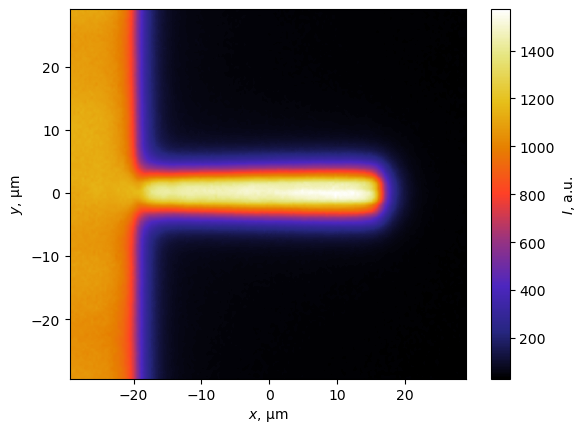

In [79]:
def interpolate_frames(image_stack, x, y, N_interp):
  """
  Проводит кубическую интерполяцию кадров cupy массива и увеличивает размер сетки.
  """
  is_numpy = isinstance(image_stack, np.ndarray)
  xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
  if is_numpy:
      import scipy.ndimage as ndimage
      import scipy.interpolate as interpolate
  else:
      import cupyx.scipy.ndimage as ndimage
      import cupyx.scipy.interpolate as interpolate

  N_z = len(image_stack)
  # Интерполируем каждый кадр стека.
  data_interp = xp.zeros((len(image_stack), N_interp, N_interp), dtype=image_stack.dtype)
  x_interp = xp.linspace(x.min(), x.max(), N_interp)
  y_interp = xp.linspace(y.min(), y.max(), N_interp)

  for i in range(N_z):

    interp = interpolate.RegularGridInterpolator((x, y), image_stack[i], method="linear",
                                        bounds_error=False, fill_value=None)
    # data_interp[i] = interp(np.meshgrid(y_interp, x_interp, indexing="ij"))
    X, Y = cp.meshgrid(x_interp, y_interp, indexing='ij')
    data_interp[i] = interp((X, Y))

    # data_interp[i] = ndimage.zoom(image_stack[i], N_interp/len(x), order=3) # order=3 задает кубическую интерполяцию

  # Создаем новые массивы координат.

  data_interp = cp.array(data_interp)


  return x_interp, y_interp, data_interp

x_interp, y_interp, data_interp = interpolate_frames(image_stack=data_final, x=x_final, y=y_final, N_interp=2**10)
plot_pcolor(x_interp.get(), y_interp.get(), data_interp[0].get())

### Деконволюция

In [80]:
import sys
sys.path.append('../')
import cupy as cp

def nearest_elem_index(elem, data):
    idx = np.where(data == data.flat[np.abs(data -  elem).argmin()])[0][0]
    print(f"nearest elem is {data[idx]}")
    return idx

import opticaldevicelib_2d as od_2d
fft2d = od_2d.OpticalDevice.ft2d
ifft2d = od_2d.OpticalDevice.ift2d

def convolution_2d(signal, kernel, v, dx, dy):

    signal_padded = np.pad(signal, ((v, v), (v, v)), 'edge')
    kernel_padded = np.pad(kernel, ((v, v), (v, v)), 'edge')

    G = fft2d(signal_padded, dx, dy)
    H = fft2d(kernel_padded, dx, dy)

    convolved = ifft2d(G * H, dx, dy)
    convolved = convolved[v:-v, v:-v]
    return convolved.real

def rl_deconv(signal, psf, bg, v, dx, dy, N_iter=None, dff=None):
    # signal = cp.array(signal)
    # psf = cp.array(psf)
    f = cp.ones(signal.shape) * 0.5

    if dff == None and N_iter != None:
        for i in range(N_iter):
            f0 = f.copy()
            ratt = signal / (convolution_2d(psf, f, v, dx, dy) + bg)
            
            f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
            stopper = np.sum(abs(f0-f))/np.sum(f)
            
            if i % 20 == 0:
                print(f"i = {i}, df/f = {stopper:1.4}")

    elif N_iter == None and dff != None:
        ii = 0
        stopper = dff + 1
        while stopper >= dff and ii < 500:
            f0 = f.copy()
            ratt = signal / (convolution_2d(psf, f, v, dx, dy) + bg)
            f *= convolution_2d(cp.flip(psf), ratt, v, dx, dy)
            stopper = np.sum(abs(f0-f))/np.sum(f0)
            if ii % 20 == 0:
                print(f"i = {ii}, df/f = {stopper:1.4}")
            ii += 1

    return f

In [81]:
dx_interp = x_interp[1]-x_interp[0]
dy_interp = y_interp[1]-y_interp[0]

data_deconv = cp.empty(shape=data_interp.shape)
# data_interp_cuda = cp.array(data_interp)

# from scipy.special import kv
from cupyx.scipy.special import k0

def psf_macdonald(x, y, a):
    X, Y = np.meshgrid(x, y)
    return a**2 / (2*np.pi) * k0(a*np.sqrt(X**2+Y**2)) 

psf_analyt = psf_macdonald(x_interp, y_interp, 1)
# psf_analyt_cuda = cp.array(psf_analyt)

from tqdm import tqdm

for i in tqdm(range(len(z_arr))):
    data_deconv[i] = rl_deconv(signal=data_interp[i], psf=psf_analyt, bg=41, dff=2e-3, v=400, dx=dx_interp, dy=dy_interp)

data_deconv = data_deconv.get()
x_interp = x_interp.get()
y_interp = y_interp.get()
data_interp = data_interp.get()

  0%|          | 0/15 [00:00<?, ?it/s]

i = 0, df/f = 7.029


  7%|▋         | 1/15 [00:00<00:11,  1.17it/s]

i = 0, df/f = 6.861


 13%|█▎        | 2/15 [00:01<00:11,  1.15it/s]

i = 0, df/f = 6.727


 20%|██        | 3/15 [00:02<00:10,  1.11it/s]

i = 0, df/f = 6.685


 27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

i = 0, df/f = 6.669


 33%|███▎      | 5/15 [00:04<00:10,  1.02s/it]

i = 0, df/f = 6.692
i = 20, df/f = 0.002861


 40%|████      | 6/15 [00:06<00:11,  1.24s/it]

i = 0, df/f = 6.651
i = 20, df/f = 0.004166


 47%|████▋     | 7/15 [00:08<00:12,  1.62s/it]

i = 0, df/f = 6.581
i = 20, df/f = 0.004584


 53%|█████▎    | 8/15 [00:11<00:13,  1.94s/it]

i = 40, df/f = 0.002107
i = 0, df/f = 6.598
i = 20, df/f = 0.003647


 60%|██████    | 9/15 [00:13<00:11,  1.97s/it]

i = 0, df/f = 6.538
i = 20, df/f = 0.00259


 67%|██████▋   | 10/15 [00:15<00:09,  1.82s/it]

i = 0, df/f = 6.417


 73%|███████▎  | 11/15 [00:16<00:06,  1.59s/it]

i = 0, df/f = 6.428


 80%|████████  | 12/15 [00:17<00:04,  1.39s/it]

i = 0, df/f = 6.42


 87%|████████▋ | 13/15 [00:17<00:02,  1.22s/it]

i = 0, df/f = 6.301


 93%|█████████▎| 14/15 [00:18<00:01,  1.09s/it]

i = 0, df/f = 6.3


100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


### Сохранение и загрузка данных

In [ ]:
import os

def cache_res(folder, model_name):
    os.makedirs(f"{folder}/{model_name}", exist_ok=True)
    np.save(f"{folder}/{model_name}/x", x_interp)
    np.save(f"{folder}/{model_name}/y", y_interp)
    np.save(f"{folder}/{model_name}/data_interp", data_interp)
    np.save(f"{folder}/{model_name}/data_deconv", data_deconv)

# cache_res("FTIAN_2", "data_cache")

In [ ]:
def read_res(folder, model_name):
    x = np.load(f"{folder}/{model_name}/x.npy")
    y = np.load(f"{folder}/{model_name}/y.npy")
    data_interp = np.load(f"{folder}/{model_name}/data_interp.npy")
    data_deconv = np.load(f"{folder}/{model_name}/data_deconv.npy")
    
    return x, y, data_interp, data_deconv

# x, y, data_interp, data_deconv = read_res("FTIAN_2", "data_cache")

### Визуализация экспериментальных данных

- $I(x, y)$, слайдер

In [82]:
# data_deconv = data_deconv.get()
def plot_pcolor_slider(x, y, z, data):

    from matplotlib.widgets import Slider
    # plt.clf()
    %matplotlib tk

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.2)
    ax.set_aspect('equal')
    # Начальное отображение
    c = ax.pcolormesh(x, y, data[0]/np.max(data[0]), rasterized=True, cmap='CMRmap', vmin=0, vmax=1)
    ax.grid()
    plt.title(f'z = {z_arr[0]}')
    plt.colorbar(c)
    # plt.xlim(-30, 32)
    # plt.ylim(-20, 20)
    # Настраиваем слайдер
    ax_slider = plt.axes([0.3, 0.05, 0.45, 0.03])  # (left, bottom, width, height)
    slider = Slider(ax_slider, 'Index', 0, len(data)-1, valinit=0, valstep=1)

    # Функция обновления графика при изменении слайдера
    def update(val):
        idx = int(slider.val)
        c.set_array(data[idx].flatten())
        # c.set_array(data[idx].flatten()/np.max(data[idx].flatten()))
        ax.set_title(f'z = {z[idx]}')
        fig.canvas.draw()

    slider.on_changed(update)


plot_pcolor_slider(x_interp, y_interp, z_arr, data_deconv/np.max(data_deconv))
# plot_pcolor_slider(x_interp, y_interp, z_arr, data/np.max(data_deconv_cut))
# plot_pcolor_slider(x_interp.get(), y_interp.get(), z_arr, data_interp.get()/np.max(data_interp.get()))

- $I(y)$, слайдер

In [89]:
lines_cache = []

def plot_slice_x_slider(x0, x, y, z, data):

    # предварительная подготовка plot
    from matplotlib.widgets import Slider 

    plt.close()
    %matplotlib tk

    # по x0 находим нужный слой в x
    N_slice = nearest_elem_index(x0, x) 
    data = data[:, :, N_slice]
    # data = data / np.max(data)

    # кэширование всех инпутов
    global lines_cache
    lines_cache.append([x0, x, y, z, data]) 

    # Инициализация графика и его свойства
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.2)
    ax.set_ylim(-0.1, 1)
    ax.set_xlim(-10, 10)
    plt.xlabel("$y$, μm")
    plt.ylabel("$I$, a.u.")
    # plt.axvline(0, color='red', linestyle='--')
    plt.axhline(y = 0.5, color = 'g', alpha=0.8, linewidth=0.5)
    ax.grid()
    
    # Создаем слайдер
    axcolor = 'lightgoldenrodyellow' 
    
    slider_ax = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor=axcolor)
    slider = Slider(slider_ax, 'Index', 0, len(data)-1, valinit=0, valstep=1)

    l_arr = []
    for line in lines_cache:
        l, = ax.plot(line[2], line[4][0])
        l_arr.append(l)

    def update(val):
        index = int(slider.val)
        for i, line in enumerate(lines_cache):
            l_arr[i].set_ydata(line[4][index])
            l_arr[i].set_xdata(line[2])
        ax.set_title(f"$z$ = {(z[index]):.0f} mm")
        fig.canvas.draw()

    slider.on_changed(update)

X0 = 0

plot_slice_x_slider(X0, x_interp, y_interp, z_arr+2, data_deconv/np.max(data_deconv))
# plot_slice_x_slider(X0, x_interp, y_interp, z_arr+2, data_interp/np.max(data_interp))

nearest elem is -0.020445944396206964


- $I(y, z)$, слайдер

In [93]:
def plot_focal_spot_slider(x, y, z, data):
    
    from matplotlib.widgets import Slider

    %matplotlib tk
    data = np.transpose(data, (2, 1, 0)) / np.max(data)

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    # ax.grid()
    # Начальное отображение
    c = ax.pcolormesh(z, y, data[0], cmap='CMRmap', vmin=0, vmax=1)
    plt.title(f'x = {x[0]:.1f}')
    plt.colorbar(c)
    plt.ylim(-6, 6)

    plt.xticks(np.arange(z[0], z[-1]+1, step=4))
    plt.yticks(np.arange(-8, 10, step=2))

    # Настраиваем слайдер
    ax_slider = plt.axes([0.17, 0.1, 0.6, 0.03])  # (left, bottom, width, height)
    slider = Slider(ax_slider, 'Index', 0, len(x)-1, valinit=0, valstep=1)

    # Функция обновления графика при изменении слайдера
    def update(val):
        idx = int(slider.val)
        c.set_array(data[idx])
        ax.set_title(f'x = {x[idx]:.1f}')
        fig.canvas.draw()

    slider.on_changed(update)
    

# plot_focal_spot_slider(x_interp, y_interp, z_arr, data_interp)
plot_focal_spot_slider(x_interp, y_interp, z_arr+2, data_deconv)

- $I(y, z)$, сохранить

nearest elem is 13.017677222759218


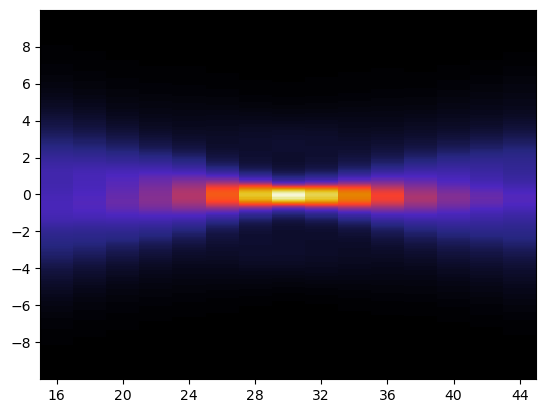

In [51]:
def plot_focal_spot_slice(x0, x, y, z, data):

    %matplotlib inline

    data = np.transpose(data, (2, 1, 0))
    N_slice = nearest_elem_index(x0, x)

    fig, ax = plt.subplots()
    fig.canvas.flush_events()
    # ax.grid()
    # plt.subplots_adjust(bottom=0.25)

    c = ax.pcolormesh(z, y, data[N_slice], shading='auto', cmap='CMRmap', vmin=0, vmax=1)
    # plt.colorbar(c)
    plt.ylim(-10, 10)
    plt.xticks(np.arange(z[0], z[-1]+1, step=4))
    plt.yticks(np.arange(-8, 8+2, step=2))
    # plt.axis("off")
    # plt.savefig(f"data_output/focal_spot/exper_up.png", bbox_inches='tight', pad_inches=0, dpi=400)
    fig.canvas.draw()


plot_focal_spot_slice(13, x_interp, y_interp, z_arr, data_deconv/np.max(data_deconv))
# plot_focal_spot_slice(-13, x_interp, y_interp, z_arr+2, data_interp/np.max(data_interp))

- $I(x,z)$, слайдер

In [63]:
def plot_focal_spot_slice_slider(y0, x, y, z, data):
    
    from matplotlib.widgets import Slider
    %matplotlib tk
    
    data = np.transpose(data, (2, 1, 0)) / np.max(data)

    print(data.shape)

    N_slice = nearest_elem_index(y0, y) 

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    ax.grid()
    # Начальное отображение
    l,  = ax.plot(x, data[:, N_slice, 0])

    # plt.title(f'x = {x[0]:.1f}')
    plt.ylim(-0.1, 1)

    # plt.xticks(np.arange(z[0], z[-1]+4, step=4))
    # plt.yticks(np.arange(-8, 10, step=2))

    # Настраиваем слайдер
    ax_slider = plt.axes([0.1, 0.1, 0.8, 0.03])  # (left, bottom, width, height)
    slider = Slider(ax_slider, 'Index', 0, len(z)-1, valinit=0, valstep=1)

    # Функция обновления графика при изменении слайдера
    def update(val):
        idx = int(slider.val)
        l.set_ydata(data[:, N_slice,  idx])
        l.set_xdata(x)
        # ax.set_title(f'x = {x[idx]:.1f}')
        

    slider.on_changed(update)

    fig.canvas.draw()

# plot_focal_spot_slider(x_interp_shift, y_interp_shift, z_arr, data_interp_shift)

plt.clf()

plot_focal_spot_slice_slider(0.1, x_interp, y_interp, z_arr, data_deconv/np.max(data_deconv))
# plot_focal_spot_slice_slider(0, x_deconv_cut, y_deconv_cut, z_arr, data_deconv_cut)

(1024, 1024, 15)
nearest elem is 0.09392355707006869
